# Project Summary

## 1. Datasets

This project leverages two comprehensive datasets provided via the Steam APIs, encompassing both game metadata and user-generated content.

### - The *Steam App Info* dataset

URL: `http://store.steampowered.com/api/appdetails/` (2M)

This dataset includes fields such as `appid`, `title`, `developer`, `publisher`, `genres`, `languages`, `tags`, `release_date`, `price`, `old_userscore`, `is_free`, `detailed_description`, `about_the_game`, `short_description`, `pc_requirements`, and `content_descriptors`. These fields are instrumental in understanding the characteristics and diversity of games available on the platform.

### - The *Steam User Reviews* dataset

URL: `https://store.steampowered.com/appreviews/{appid}?json=1&filter=updated&language=english&cursor={encoded_cursor}&num_per_page=100&key={api_key}` (50k)

This dataset captures user interactions and opinions, detailed by attributes like `recommendationid`, `steamid`, `num_games_owned`, `num_reviews`, `playtime_forever`, `playtime_last_two_weeks`, `playtime_at_review`, `last_played`, `language`, `review`, `timestamp_created`, `timestamp_updated`, `voted_up`, `votes_up`, `votes_funny`, `weighted_vote_score`, `comment_count`, `steam_purchase`, `received_for_free`, `written_during_early_access`, and `developer_response`. These datasets encompass both quantitative and qualitative data, providing a rich foundation for analyzing user preferences and behaviors towards gaming content.

## 2. Research Question

The core objective of this study is to explore the feasibility of developing a recommender system that can suggest games to users based on their historical review sentiments and playtime metrics. This question probes the intersection of user-generated content analysis and predictive modeling to enhance personalization and user experience on digital platforms.

## 3. Model Design

The analytical framework of this project is structured around the application of machine learning models and algorithms tailored to interpret the complex dataset characteristics. The project employs a dual approach, integrating Sentiment Analysis, Collaborative Filtering, and Content-Based Filtering.

### 3.1 Sentiment Analysis and Collaborative Filtering

#### 3.1.1 Sentiment Analysis

For sentiment analysis, the project leverages the advanced capabilities of vader's SentimentIntensityAnalyzer which is highly compatible with Spark's API. Vader is also appropriate because it takes into account informal language and slang which is often found in steam game reviews. The sentiment analysis process is enhanced by utilizing NLP techniques such as tokenization, stemming, and stop word removal to preprocess review texts, improving the model's ability to focus on relevant sentiment indicators.

#### 3.1.2 Collaborative Filtering

The collaborative filtering component employs the Top-K Nearest Neighbors algorithm, a variant of the K-Nearest Neighbors (KNN) algorithm, optimized for large datasets and designed to identify similarities among users based on a vector space model. User vectors are constructed from features such as playtime metrics (total playtime, playtime in the last two weeks, playtime at the time of review), sentiment scores derived from reviews, and engagement metrics (votes up, votes funny, number of games owned, review count).

This algorithm calculates similarity scores using a cosine similarity measure, identifying the top-K users most similar to a given user. Recommendations are then generated based on the gaming preferences of these similar users, weighted by their similarity scores. This approach not only leverages shared experiences within the user community but also incorporates sentiment analysis results to provide a nuanced understanding of user preferences, significantly enhancing the personalized recommendation system.

### 3.2 Content-Based Filtering

For content-based filtering, the methodological approach focuses on the application of cosine similarity to compare user profiles with game characteristics. This is achieved by constructing feature vectors from concatenated attributes from both the Steam App Info and Steam User Reviews datasets.

From the Steam App Info dataset, the "tags" vector includes attributes such as `developer`, `publisher`, `genres`, `languages`, `tags`, `release_date`, `price`, `old_userscore`, `is_free`, and `detailed_description`, `about_the_game`, `short_description`, `pc_requirements`, and `content_descriptors`. From the Steam User Reviews dataset, the feature vector incorporates metrics like `total_playtime_forever`, `total_playtime_last_two_weeks`, and a textual analysis of the 50 most common words across all reviews for a game.
These attributes provide a comprehensive view of each game, reflecting its thematic elements, gameplay mechanics, and overall content, which are essential for aligning games with user preferences.

The cosine similarity calculation is then applied to these feature vectors, identifying games with the highest similarity scores to a user's games profile, based on their past interactions and sentiment towards a game. This approach facilitates highly personalized game recommendations, ensuring users are introduced to titles that closely match their interests and gameplay preferences.


# A. Environment setup and Initializing Spark

In [ ]:
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Sparks.
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.
!pip install gdown

In [ ]:
# Env
import os
import findspark
from pyspark.sql import SparkSession

# Used Imports
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, HashingTF, IDF, Tokenizer, Normalizer, StopWordsRemover
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import RankingMetrics
from pyspark.ml import Pipeline, Transformer
from pyspark.sql.types import LongType, IntegerType, FloatType, DoubleType, ArrayType, StringType
from pyspark.sql.functions import concat, col, lit, split, concat_ws, udf, collect_list
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import expr, col, udf
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param

# General and Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

# Imports for Sentiment Analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
# Set environment variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

!ls

# Initialize findspark
findspark.init()

# Create a PySpark session
spark = SparkSession.builder.master("local[*]").appName("Steam_Recommendation_Engine").config("spark.jars", "/content/postgresql-42.7.3.jar").getOrCreate()
spark

labelled_steam_reviews.csv  spark-3.1.1-bin-hadoop3.2.tgz    spark-3.1.1-bin-hadoop3.2.tgz.3
sample_data		    spark-3.1.1-bin-hadoop3.2.tgz.1  steam_app_info_rows_from_supabase.csv
spark-3.1.1-bin-hadoop3.2   spark-3.1.1-bin-hadoop3.2.tgz.2  steam_reviews_from_supabase.csv


In [ ]:
!gdown https://drive.google.com/uc?id=1sbvsH05ADaGTuKNYooLtqp-iIveHNWye
!gdown https://drive.google.com/uc?id=1_eV449Z_yvPy5qljOzeHrjJ3FOKHU4SU
!gdown https://drive.google.com/uc?id=1SkrVhoo3Mt8sYuv6fpnhhoM-KEGO6oKw

Downloading...
From (original): https://drive.google.com/uc?id=1sbvsH05ADaGTuKNYooLtqp-iIveHNWye
From (redirected): https://drive.google.com/uc?id=1sbvsH05ADaGTuKNYooLtqp-iIveHNWye&confirm=t&uuid=34294cc3-3fa2-47bc-8155-f383cf93e740
To: /content/steam_reviews_from_supabase.csv
100% 690M/690M [00:11<00:00, 62.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_eV449Z_yvPy5qljOzeHrjJ3FOKHU4SU
To: /content/steam_app_info_rows_from_supabase.csv
100% 612k/612k [00:00<00:00, 39.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SkrVhoo3Mt8sYuv6fpnhhoM-KEGO6oKw
To: /content/labelled_steam_reviews.csv
100% 45.2k/45.2k [00:00<00:00, 52.3MB/s]


# B. Loading data from Postgres DB/CSV

In [ ]:
# Load steam_app_info table with settings for complex patterns
steam_app_info = spark.read.option("header", "true") \
                           .option("inferSchema", "true") \
                           .option("multiLine", "true") \
                           .option("quote", "\"") \
                           .option("escape", "\"") \
                           .csv("/content/steam_app_info_rows_from_supabase.csv")

# Load steam_reviews table with settings for complex patterns
steam_reviews_df_main = spark.read.option("header", "true") \
                             .option("inferSchema", "true") \
                             .option("multiLine", "true") \
                             .option("quote", "\"") \
                             .option("escape", "\"") \
                             .csv("/content/steam_reviews_from_supabase.csv")


In [ ]:
steam_reviews_df_filtered = steam_reviews_df_main.withColumn("appid", col("appid").cast(LongType())) \
                                                  .withColumn("steamid", col("steamid").cast(LongType()))

# Filter out rows where the cast resulted in nulls, implying the original value was non-numeric
steam_reviews_df_filtered = steam_reviews_df_filtered.filter(col("appid").isNotNull() & col("steamid").isNotNull())

steam_reviews_df = steam_reviews_df_filtered.orderBy(col("playtime_forever").desc()).limit(100000)

steam_reviews_df.show()

+-------+----------------+-----------------+---------------+-----------+----------------+-----------------------+------------------+-----------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+
|  appid|recommendationid|          steamid|num_games_owned|num_reviews|playtime_forever|playtime_last_two_weeks|playtime_at_review|last_played|              review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|
+-------+----------------+-----------------+---------------+-----------+----------------+-----------------------+------------------+-----------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+
|1593350|       140

In [ ]:
steam_app_info.show(20)

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-------+-------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  appid|               title|           developer|           publisher|              genres|           languages|                tags|release_date|  price|old_userscore|is_free|detailed_description|      about_the_game|   short_description|     pc_requirements| content_descriptors|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-------+-------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    730|    Counter-Strike 2|               Valve|               Valve|Action, Free to Play|Czech, Danish, Du...|Multi-player, Cro...|  2012-08-21|

# C. Sentiment Analysis

In [ ]:
nltk.download("vader_lexicon")

# Takes a tokenized review (with stopwords removed), and returns sentiment analysis.
# returns a value between 0 and 1 (0 for negative, 0.5 for neutral, and 1 for positive)
def analyze_sentiment(words):
  review = ' '.join(words)
  sid = SentimentIntensityAnalyzer()
  sentiment_score = sid.polarity_scores(review)["compound"]
  normalized_score = (sentiment_score + 1) / 2
  return normalized_score


df = steam_reviews_df.select(
    F.col("steamid").cast("bigint"),
    F.col("appid").cast("bigint"),
    F.col("review").cast("string")
)
df1 = df.fillna({"review": ""})

# tokenize reviews
tokenized_df = df1.withColumn("words", split(df1["review"], " "))

# remove stopwords from words column
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_review")
filtered_df = stopwords_remover.transform(tokenized_df)

# define a udf function which will be applied to filtered_review column
udf_task = udf(analyze_sentiment, FloatType())

# obtain sentiment scores using vader
sentiment_df = filtered_df.withColumn("sentiment", udf_task(filtered_df["filtered_review"]))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
sentiment_df_2 = sentiment_df.select(
    F.col("steamid").cast("bigint"),
    F.col("appid").cast("integer"),
    F.col("sentiment").cast("float")
).na.fill(0.5).filter(F.col("steamid") != 0)

In [ ]:
sentiment_df_2.
 ()
sentiment_df_2.head()

Row(steamid=76561199191292944, appid=1593350, sentiment=0.7202000021934509)

In [ ]:
sentiment_df_2.show()

+-----------------+-------+---------+
|          steamid|  appid|sentiment|
+-----------------+-------+---------+
|76561199191292944|1593350|   0.7202|
|76561198295771136|    570|   0.8825|
|76561198368699688| 244850|   0.8404|
|76561198171400958|1063730|  0.60115|
|76561198151356748|  24010|   0.7202|
|76561198235865434|1366800|     0.93|
|76561198372503800| 383120|   0.4742|
|76561197988614208| 578080|  0.83525|
|76561198280384994| 244850|   0.7997|
|76561198258916256| 594570|     0.67|
|76561198123447648|  72850|   0.7202|
|76561198979418496| 578080|   0.0278|
|76561198091616038| 451340|   0.0696|
|76561198094013920|1225330|      0.5|
|76561199078762858| 410900|   0.2447|
|76561198262779328|1569040|  0.81245|
|76561198277093486|  47890|  0.57655|
|76561197966783344|  48700|  0.60115|
|76561197980931200| 489630|      0.5|
|76561198231740144|2058180|    0.754|
+-----------------+-------+---------+
only showing top 20 rows



In [ ]:
print(sentiment_df_2.count())

100000


In [ ]:
# evaluate vader's sentiment analyzer using a set of 100 labelled data
nltk.download("punkt")
nltk.download("stopwords")

def get_sentiment(review):
  sid = SentimentIntensityAnalyzer()
  sentiment_score = sid.polarity_scores(text=review)['compound']
  if sentiment_score >= 0.05:
      return 1
  elif sentiment_score <= -0.05:
      return -1
  else:
      return 0

def evaluate_accuracy(filename): # filename is the labelled steam reviews
  df = pd.read_csv(filename, header='infer')
  correct_count = 0
  total = 0
  for i, row in df.iterrows():
      total += 1
      sentiment_score = get_sentiment(row["review"])
      if sentiment_score == row["actual_sentiment"]:
          correct_count += 1
  return correct_count, total, correct_count / total


def evaluate_f1_score(filename): # filename is the labelled steam reviews
  df = pd.read_csv(filename, header='infer')
  df["vader_sentiment"] = df["review"].apply(get_sentiment)
  df["vader_sentiment"] = df["vader_sentiment"].astype(str)
  df["actual_sentiment"] = df["actual_sentiment"].astype(str)
  score = f1_score(df["actual_sentiment"].values, df["vader_sentiment"].values,
                    labels=[-1, 0, 1], average='weighted')
  return score


def evaluate_class_sizes(filename): # return number of -1s, 0s, and 1s in actual_sentiment row
  df = pd.read_csv(filename, header='infer')
  negative_count, neutral_count, positive_count = 0, 0, 0
  for i, row in df.iterrows():
      current = str(row["actual_sentiment"])
      if current == "-1":
          negative_count += 1
      elif current == "0":
          neutral_count += 1
      else:
          positive_count += 1
  return negative_count, neutral_count, positive_count

def generate_confusion_matrix(filename):
  df = pd.read_csv(filename, header='infer')
  df["vader_sentiment"] = df["review"].apply(get_sentiment)
  matrix = confusion_matrix(df["actual_sentiment"], df["vader_sentiment"])

  labels = ["negative", "neutral", "positive"]
  sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.xlabel("predicted")
  plt.ylabel("actual")
  plt.title("Confusion Matrix")
  plt.show()

def generate_word_cloud(filename):
  sample_df = sentiment_df.select(
      F.col("filtered_review").cast(ArrayType(StringType())),
    F.col("sentiment").cast("float")
  ).limit(200)

  exploded_df = sample_df.select(F.explode("filtered_review").alias("filtered_words"), "sentiment")
  positive_df = exploded_df.filter(exploded_df["sentiment"] >= 0.5).select("filtered_words")
  negative_df = exploded_df.filter(exploded_df["sentiment"] < 0.05).select("filtered_words")

  # obtain two strings, one for all positive words and one for all negative words
  positive_words = positive_df.rdd.map(lambda x: x[0]).collect()
  positive_words_string = " ".join(positive_words)
  negative_words = negative_df.rdd.map(lambda x: x[0]).collect()
  negative_words_string = " " .join(negative_words)

  # create a positive and negative word cloud and plot them
  positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_words_string)
  negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_words_string)
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.imshow(positive_wordcloud, interpolation='bilinear')
  plt.title('Positive Words')
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(negative_wordcloud, interpolation='bilinear')
  plt.title('Negative Words')
  plt.axis('off')
  plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



The accuracy of vader SentimentIntensityAnalyzer measured over 100 data points is 0.74


The f1 score of vader SentimentIntensityAnalyzer measured over 100 data points is 0.7454544695071011


From the data we manually labelled, this was how the dataset varied
negative count: 13
neutral count: 18
positive count: 69
total count: 100





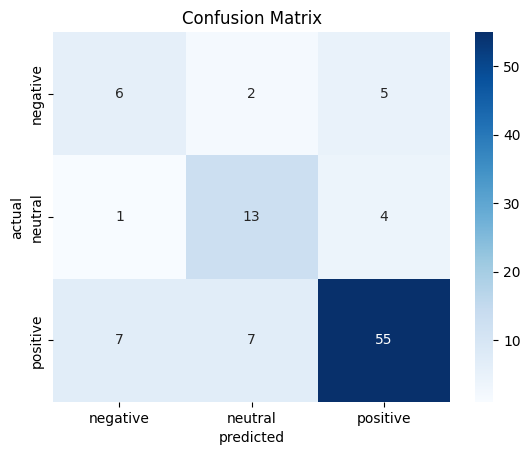

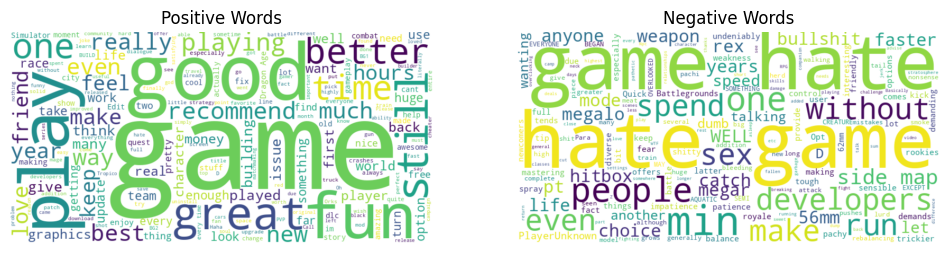

In [ ]:
_, _, accuracy = evaluate_accuracy("labelled_steam_reviews.csv")
print(f"\nThe accuracy of vader SentimentIntensityAnalyzer measured over 100 data points is {accuracy}")

score = evaluate_f1_score("labelled_steam_reviews.csv")
print(f"\n\nThe f1 score of vader SentimentIntensityAnalyzer measured over 100 data points is {score}")

negative_count, neutral_count, positive_count = evaluate_class_sizes("labelled_steam_reviews.csv")
print(f"\n\nFrom the data we manually labelled, this was how the dataset varied")
print(f"negative count: {negative_count}\nneutral count: {neutral_count}"
      f"\npositive count: {positive_count}\ntotal count: {negative_count + neutral_count + positive_count}")

print("\n\n")
generate_confusion_matrix("labelled_steam_reviews.csv")

print("\n\n")
generate_word_cloud("labelled_steam_reviews.csv")

# D. Collaborative Filtering

In [ ]:
# Data preprocessing
features_df = steam_reviews_df.select(
    F.col("steamid").cast("bigint"),
    F.col("appid").cast("integer"),
    F.col("playtime_forever").cast("float").alias("raw_rating"),
    F.col("num_games_owned").cast("integer"),
    F.col("num_reviews").cast("integer"),
    F.col("playtime_last_two_weeks").cast("float"),
    F.col("playtime_at_review").cast("float"),
    F.col("votes_up").cast("integer"),
    F.col("votes_funny").cast("integer"),
    F.col("steam_purchase").cast("integer")
).na.fill(0)

features_df.cache()
features_df.show(5)

+-----------------+-------+----------+---------------+-----------+-----------------------+------------------+--------+-----------+--------------+
|          steamid|  appid|raw_rating|num_games_owned|num_reviews|playtime_last_two_weeks|playtime_at_review|votes_up|votes_funny|steam_purchase|
+-----------------+-------+----------+---------------+-----------+-----------------------+------------------+--------+-----------+--------------+
|76561199191292944|1593350|       0.0|              0|          5|                    0.0|           34856.0|       0|          0|             0|
|76561198295771136|    570|   99999.0|              0|          1|                    0.0|            9903.0|       0|          0|             0|
|76561198368699688| 244850|   99999.0|             48|          5|                  922.0|           30593.0|       0|          0|             0|
|76561198171400958|1063730|   99999.0|            109|          3|                    0.0|           98718.0|       0|      

In [ ]:
filtered_features_df = features_df.filter((F.col("steamid") != 0) & (F.col("appid") != 0))

filtered_features_df.show(5)

+-----------------+-------+----------+---------------+-----------+-----------------------+------------------+--------+-----------+--------------+
|          steamid|  appid|raw_rating|num_games_owned|num_reviews|playtime_last_two_weeks|playtime_at_review|votes_up|votes_funny|steam_purchase|
+-----------------+-------+----------+---------------+-----------+-----------------------+------------------+--------+-----------+--------------+
|76561199191292944|1593350|       0.0|              0|          5|                    0.0|           34856.0|       0|          0|             0|
|76561198295771136|    570|   99999.0|              0|          1|                    0.0|            9903.0|       0|          0|             0|
|76561198368699688| 244850|   99999.0|             48|          5|                  922.0|           30593.0|       0|          0|             0|
|76561198171400958|1063730|   99999.0|            109|          3|                    0.0|           98718.0|       0|      

In [ ]:
max_min_steamid_df = filtered_features_df.agg(
    F.max("steamid").alias("max_steamid"),
    F.min("steamid").alias("min_steamid")
)

max_min_steamid_df.show()

+-----------------+-----------------+
|      max_steamid|      min_steamid|
+-----------------+-----------------+
|76561199643570208|76561197960268079|
+-----------------+-----------------+



In [ ]:
lowest_min_id = max_min_steamid_df.collect()[0]["min_steamid"] -1
print(lowest_min_id)
# Subtract (lowest_min_id + 1) from all steamid in filtered_features_df and update the column
adjusted_features_df = filtered_features_df.withColumn("adjusted_steamid", F.col("steamid") - lowest_min_id)

# Show the result to verify the adjustment
adjusted_features_df.show(5)

76561197960268078
+-----------------+-------+----------+---------------+-----------+-----------------------+------------------+--------+-----------+--------------+----------------+
|          steamid|  appid|raw_rating|num_games_owned|num_reviews|playtime_last_two_weeks|playtime_at_review|votes_up|votes_funny|steam_purchase|adjusted_steamid|
+-----------------+-------+----------+---------------+-----------+-----------------------+------------------+--------+-----------+--------------+----------------+
|76561199191292944|1593350|       0.0|              0|          5|                    0.0|           34856.0|       0|          0|             0|      1231024866|
|76561198295771136|    570|   99999.0|              0|          1|                    0.0|            9903.0|       0|          0|             0|       335503058|
|76561198368699688| 244850|   99999.0|             48|          5|                  922.0|           30593.0|       0|          0|             0|       408431610|
|765

In [ ]:
# Visualizing the distribution of 'playtime_forever' before normalization
sampled_df = filtered_features_df.sample(withReplacement=False, fraction=0.01)  # 1% sampling
pandas_sampled_df = sampled_df.toPandas()

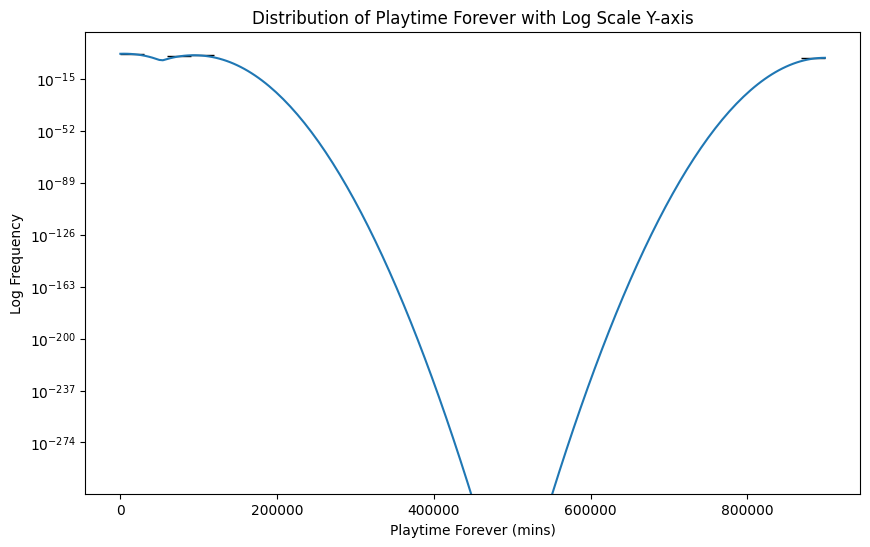

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(pandas_sampled_df['raw_rating'], bins=30, kde=True, log_scale=(False, True))
plt.title('Distribution of Playtime Forever with Log Scale Y-axis')
plt.xlabel('Playtime Forever (mins)')
plt.ylabel('Log Frequency')
plt.show()

In [ ]:
filter_df = adjusted_features_df.join(sentiment_df_2, on=['steamid', 'appid'], how='inner').na.fill(0.5) # include sentiments in the feature vector
filter_df.cache()
filter_df.show()

+-----------------+-------+----------+---------------+-----------+-----------------------+------------------+--------+-----------+--------------+----------------+---------+
|          steamid|  appid|raw_rating|num_games_owned|num_reviews|playtime_last_two_weeks|playtime_at_review|votes_up|votes_funny|steam_purchase|adjusted_steamid|sentiment|
+-----------------+-------+----------+---------------+-----------+-----------------------+------------------+--------+-----------+--------------+----------------+---------+
|76561199191292944|1593350|       0.0|              0|          5|                    0.0|           34856.0|       0|          0|             0|      1231024866|   0.7202|
|76561198295771136|    570|   99999.0|              0|          1|                    0.0|            9903.0|       0|          0|             0|       335503058|   0.8825|
|76561198368699688| 244850|   99999.0|             48|          5|                  922.0|           30593.0|       0|          0|     

In [ ]:
# normalizing features (excluding 'steamid' and 'appid')

feature_cols = filter_df.columns[2:]  # Excluding 'steamid' and 'appid'
print(feature_cols)

['raw_rating', 'num_games_owned', 'num_reviews', 'playtime_last_two_weeks', 'playtime_at_review', 'votes_up', 'votes_funny', 'steam_purchase', 'adjusted_steamid', 'sentiment']


In [ ]:
# Custom Transformer for calculating composite score
class CompositeScoreTransformer(Transformer, HasInputCol, HasOutputCol):
    """
    A custom Transformer which applies weighted scores to features.
    """

    def __init__(self, inputCol="scaled_features", outputCol="composite_score"):
        super(CompositeScoreTransformer, self).__init__()
        self._setDefault(inputCol=inputCol, outputCol=outputCol)
        self.setParams(**{param.name: val for param, val in zip(self.params, (inputCol, outputCol))})

    def setParams(self, inputCol="scaled_features", outputCol="composite_score"):
        kwargs = {param.name: val for param, val in zip(self.params, (inputCol, outputCol))}
        return self._set(**kwargs)

    def _transform(self, dataset):
        # ['raw_rating', 'num_games_owned', 'num_reviews', 'playtime_last_two_weeks', 'playtime_at_review', 'votes_up', 'votes_funny', 'steam_purchase', 'adjusted_steamid', 'sentiment']
        weights = Vectors.dense([0.2, 0.02, 0.02, 0.02, 0.6, 0.02, 0, 0.02, 0,0.1])

        def calculate_composite_score(scaled_features):
            return float(scaled_features.dot(weights))

        calculate_score_udf = F.udf(calculate_composite_score, DoubleType())

        return dataset.withColumn(self.getOutputCol(), calculate_score_udf(self.getInputCol()))

In [ ]:
# creating the pipeline stages to include the custom Transformer
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
composite_score_transformer = CompositeScoreTransformer(inputCol="scaled_features", outputCol="composite_score")

als = ALS(
    maxIter=20,
    regParam=0.05,
    userCol="adjusted_steamid",
    itemCol="appid",
    ratingCol="composite_score",  # Use composite score as the rating
    coldStartStrategy="drop",
    nonnegative=True,
    implicitPrefs=False
)

pipeline = Pipeline(stages=[assembler, scaler, composite_score_transformer, als])


In [ ]:
train_data, test_data = filter_df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)

In [ ]:
# normalized RMSE evaluation
predictions = model.transform(test_data)
predictions = predictions.na.drop(subset=["prediction"])
predictions = predictions.withColumn("prediction", F.when(F.isnan(F.col("prediction")) | F.col("prediction").isNull(), F.lit(0)).otherwise(F.col("prediction")))

In [ ]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="composite_score", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Normalized Root-mean-square error: {rmse}")

Normalized Root-mean-square error: 0.06950066419501176


In [ ]:
print("{:.2f}".format(rmse * 100) + "%")

6.95%


In [ ]:
# MAE
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="composite_score", predictionCol="prediction")
mae = mae_evaluator.evaluate(predictions)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.06456581456784635


In [ ]:
print("{:.2f}".format(mae * 100) + "%")

6.46%


In [ ]:
def recommendAppIdsUsingCollaborative(pipelineModel, steamId, numRecs=5):
    adjusted_steamId = steamId - lowest_min_id

    alsModel = [stage for stage in pipelineModel.stages if isinstance(stage, ALSModel)][0]

    users = spark.createDataFrame([(adjusted_steamId,)], ["adjusted_steamid"])

    recommendations = alsModel.recommendForUserSubset(users, numRecs)
    recommended_app_ids = recommendations \
                            .select("recommendations.appid", "recommendations.rating") \
                            .collect()[0]

    return recommended_app_ids

In [ ]:
print(recommendAppIdsUsingCollaborative(model, 76561198295771136))

Row(appid=[570, 1283970, 109600, 10, 872790], rating=[0.09084176272153854, 0.08035741746425629, 0.05420360714197159, 0.05311170220375061, 0.05129747837781906])


In [ ]:
print(recommendAppIdsUsingCollaborative(model, 76561198295771136))

Row(appid=[786520, 570, 252490, 730, 4000], rating=[0.0084608169272542, 0.006587790325284004, 0.004730581771582365, 0.0030721724033355713, 0.0028942017816007137])


User 76561198295771136 spent 9903 time units on playing Dota2. None of his other reviews were noted in sub sampled dataset.

App Ids recommended: 786520, 570, 252490, 730, 4000, 8500, 9900, 32470, 346110, 570,Dota 2
730,Counter-Strike 2
4000,Garry's Mod
8500,EVE Online
9900,Star Trek Online
32470,STAR WARS™ Empire at War - Gold Pack
252490,Rust
346110,ARK: Survival Evolved
786520,SAO Utils: Beta
1366540,Dyson Sphere Program

# E. Content based

In [ ]:
# Fill null values in text columns with empty strings before concatenation
fill_dict = {
    "genres": "", "tags": "", "developer": "", "publisher": "", "languages": "",
    "release_date": "", "price": "0", "old_userscore": "0", "is_free": "",
    "detailed_description": "", "about_the_game": "", "short_description": "",
    "pc_requirements": "", "content_descriptors": ""
}

steam_app_info_df = steam_app_info.fillna(fill_dict).withColumn("text_features",
                                               concat_ws(" ",
                                                         col("genres"),
                                                         col("tags"),
                                                         col("developer"),
                                                         col("publisher"),
                                                         col("languages"),
                                                         col("release_date"),
                                                         col("price").cast("string"),
                                                         col("old_userscore").cast("string"),
                                                         col("is_free").cast("string"),
                                                         col("detailed_description"),
                                                         col("about_the_game"),
                                                         col("short_description"),
                                                         col("pc_requirements"),
                                                         col("content_descriptors")))

In [ ]:
# Tokenize, HashingTF, IDF, and Normalize
tokenizer = Tokenizer(inputCol="text_features", outputCol="words")
wordsData = tokenizer.transform(steam_app_info_df)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
featurizedData = hashingTF.transform(wordsData)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

normalizer = Normalizer(inputCol="features", outputCol="normFeatures")
normalizedData = normalizer.transform(rescaledData)

In [ ]:
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

def average_features(feature_lists):
    return [np.mean([features[i] for features in feature_lists]) for i in range(len(feature_lists[0]))]

average_features_udf = udf(average_features, ArrayType(DoubleType()))

# User Preferences to Feature Arrays
userPreferences = steam_reviews_df.select("steamid", "appid", "playtime_forever")
userPreferences = userPreferences.withColumn("preference", (col("playtime_forever") / 100).cast(IntegerType()))

userGameFeatures = userPreferences.join(normalizedData, userPreferences.appid == normalizedData.appid).select("steamid", "normFeatures", "preference")
userGameFeatures = userGameFeatures.withColumn("featuresArray", vector_to_array_udf("normFeatures"))

userFeaturesCollected = userGameFeatures.groupBy("steamid").agg(collect_list("featuresArray").alias("featuresList"))

average_features_udf = udf(average_features, ArrayType(DoubleType()))
userProfileFeatures = userFeaturesCollected.withColumn("userProfileFeatures", average_features_udf("featuresList"))

In [ ]:
@udf(returnType=FloatType())
def cosine_similarity(arr1, arr2):
    # Assume arr1 and arr2 are already in the correct format for calculation
    similarity = np.dot(arr1, arr2) / (np.linalg.norm(arr1) * np.linalg.norm(arr2))
    return float(similarity)  # Convert from numpy.float64 to Python float

In [ ]:
def recommendGames(appId=None, numRecs=10):
    recommendations = None
    if appId is not None and appId != 0:
        # Fetch the game vector for the specified appId
        gameFeatures = normalizedData.filter(col("appid") == appId).select("normFeatures").first()
        if gameFeatures and gameFeatures.normFeatures:
            # Cross join with normalizedData to compare with all games, then calculate similarity
            # Using aliases to avoid column name ambiguity
            singleGameFeatures = normalizedData.filter(col("appid") == appId).alias("game")
            allGames = normalizedData.alias("all_games")

            # Perform cross join and calculate similarity
            comparisons = singleGameFeatures.crossJoin(allGames).select(
                col("game.appid").alias("game_appid"),
                col("all_games.appid").alias("all_games_appid"),
                "game.normFeatures",
                "all_games.normFeatures"
            )

            # Calculate similarity
            comparisons = comparisons.withColumn("similarity", cosine_similarity(col("game.normFeatures"), col("all_games.normFeatures")))

            # Filter to exclude the game itself from its recommendations
            comparisons = comparisons.filter(comparisons.game_appid != comparisons.all_games_appid)

            # Select top N similar games
            recommendations = comparisons.orderBy("similarity", ascending=False).limit(numRecs)
    if recommendations:
        return recommendations.collect()
    else:
        print("Please provide either an appId or a steamId.")
        return None

In [ ]:
#Dota 2
response = (recommendGames(appId=570, numRecs=10))

# Sort the response by similarity score in descending order
sorted_response = sorted(response, key=lambda x: x.similarity, reverse=True)

# Select the top 5 recommendations
top_5_recommendations = sorted_response[:5]

# Print the top 5 recommended game IDs
for recommendation in top_5_recommendations:
    print(f"Game AppID: {recommendation.all_games_appid}, Similarity: {recommendation.similarity}")

Game AppID: 1599340, Similarity: 0.2660299241542816
Game AppID: 730, Similarity: 0.2502953112125397
Game AppID: 500, Similarity: 0.22840118408203125
Game AppID: 1466860, Similarity: 0.22273610532283783
Game AppID: 628070, Similarity: 0.22163820266723633


In [ ]:
#FIFA 23
response = (recommendGames(appId=1811260, numRecs=10))

# Sort the response by similarity score in descending order
sorted_response = sorted(response, key=lambda x: x.similarity, reverse=True)

# Select the top 5 recommendations
top_5_recommendations = sorted_response[:5]

# Print the top 5 recommended game IDs
for recommendation in top_5_recommendations:
    print(f"Game AppID: {recommendation.all_games_appid}, Similarity: {recommendation.similarity}")

Game AppID: 1158850, Similarity: 0.21725936233997345
Game AppID: 2195250, Similarity: 0.2066352218389511
Game AppID: 1692250, Similarity: 0.2035447210073471
Game AppID: 1506830, Similarity: 0.183664008975029
Game AppID: 629760, Similarity: 0.16137275099754333


In [ ]:
#NARUTO SHIPPUDEN: Ultimate Ninja STORM 4
response = (recommendGames(appId=349040, numRecs=10))

# Sort the response by similarity score in descending order
sorted_response = sorted(response, key=lambda x: x.similarity, reverse=True)

# Select the top 5 recommendations
top_5_recommendations = sorted_response[:5]

# Print the top 5 recommended game IDs
for recommendation in top_5_recommendations:
    print(f"Game AppID: {recommendation.all_games_appid}, Similarity: {recommendation.similarity}")

Game AppID: 1089090, Similarity: 0.28043535351753235
Game AppID: 851850, Similarity: 0.24462489783763885
Game AppID: 527230, Similarity: 0.21811512112617493
Game AppID: 976730, Similarity: 0.21737462282180786
Game AppID: 418530, Similarity: 0.21455271542072296


# F. Evaluation

In [ ]:
# Evaluation Part 1: Collaborative Filtering Accuracy
# ----------------------------------------------------
# Assuming 'predictions' DataFrame from Collaborative Filtering (Section D) is already defined
# Use RMSE to evaluate accuracy
reg_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="normalized_rating", metricName="rmse")
rmse = reg_evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) for Collaborative Filtering: {rmse}")

# Evaluation Part 2: Ranking Effectiveness
# -----------------------------------------
# Convert predictions to an RDD of format needed for RankingMetrics
# Adjust as necessary for your specific data structure
preds_and_labels = predictions.select("prediction", "normalized_rating").rdd.map(tuple)
ranking_metrics = RankingMetrics(preds_and_labels)
print(f"Mean Average Precision for Collaborative Filtering Recommendations: {ranking_metrics.meanAveragePrecision}")

# Evaluation Part 3: Content-Based Filtering Effectiveness
# --------------------------------------------------------
# Step 1: Classify 'likes' based on playtime
playtime_threshold = 6000  # Threshold in minutes for likes
steam_reviews_df = steam_reviews_df.withColumn("like", (col("playtime_forever") > playtime_threshold).cast(IntegerType()))

recommendations_df = spark.createDataFrame(response)

# Step 2: Join recommendations with user preferences
recommendations_df = recommendations_df.withColumn("recommended", lit(1))

# Joining on appid
joined_df = recommendations_df.join(steam_reviews_df, on=recommendations_df.all_games_appid == steam_reviews_df.appid, how="left")

# Calculating True Positives (TP), False Positives (FP), and False Negatives (FN)
# TP: Recommended and liked
TP = joined_df.filter("recommended = 1 AND like = 1").count()
# FP: Recommended but not liked
FP = joined_df.filter("recommended = 1 AND (like = 0 OR like IS NULL)").count()
# To calculate FN, checking the full list of liked items against what was recommended.
liked_not_recommended_df = steam_reviews_df.filter("like = 1").subtract(joined_df.filter("recommended = 1 AND like = 1").select(steam_reviews_df.columns))
FN = liked_not_recommended_df.count()

# Now calculate Precision and Recall
precision = TP / (TP + FP) if TP + FP > 0 else 0
recall = TP / (TP + FN) if TP + FN > 0 else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")


# Evaluation Part 4: Sentiment Analysis Assessment
# -------------------------------------------------
# Assess the correlation between sentiment scores and user preferences or behaviors
# Placeholder for sentiment analysis correlation assessment
# sentiment_correlation = calculate_sentiment_correlation(steam_reviews_df)
# print(f"Correlation Between Sentiment Scores and User Preferences: {sentiment_correlation}")

# Evaluation Part 5: Overall User Satisfaction
# --------------------------------------------
# Assuming you have user feedback or survey data related to the recommendations
# Placeholder for user satisfaction survey data analysis
# user_feedback_df = spark.read.csv("/path/to/user_feedback.csv", header=True, inferSchema=True)
# Analyze feedback to gauge overall satisfaction with the recommender system
# satisfaction_rate = calculate_user_satisfaction(user_feedback_df)
# print(f"User Satisfaction Rate: {satisfaction_rate}")

# Summary
print("Evaluation Summary: Adjust model parameters, recommendation logic, or sentiment analysis based on these insights for improvement.")
